C:\Users\mair\AppData\Local\Temp\ipykernel_529984\2311589366.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group[numerical_var].dropna() for name, group in data.groupby(cat_var) if not group[numerical_var].empty]


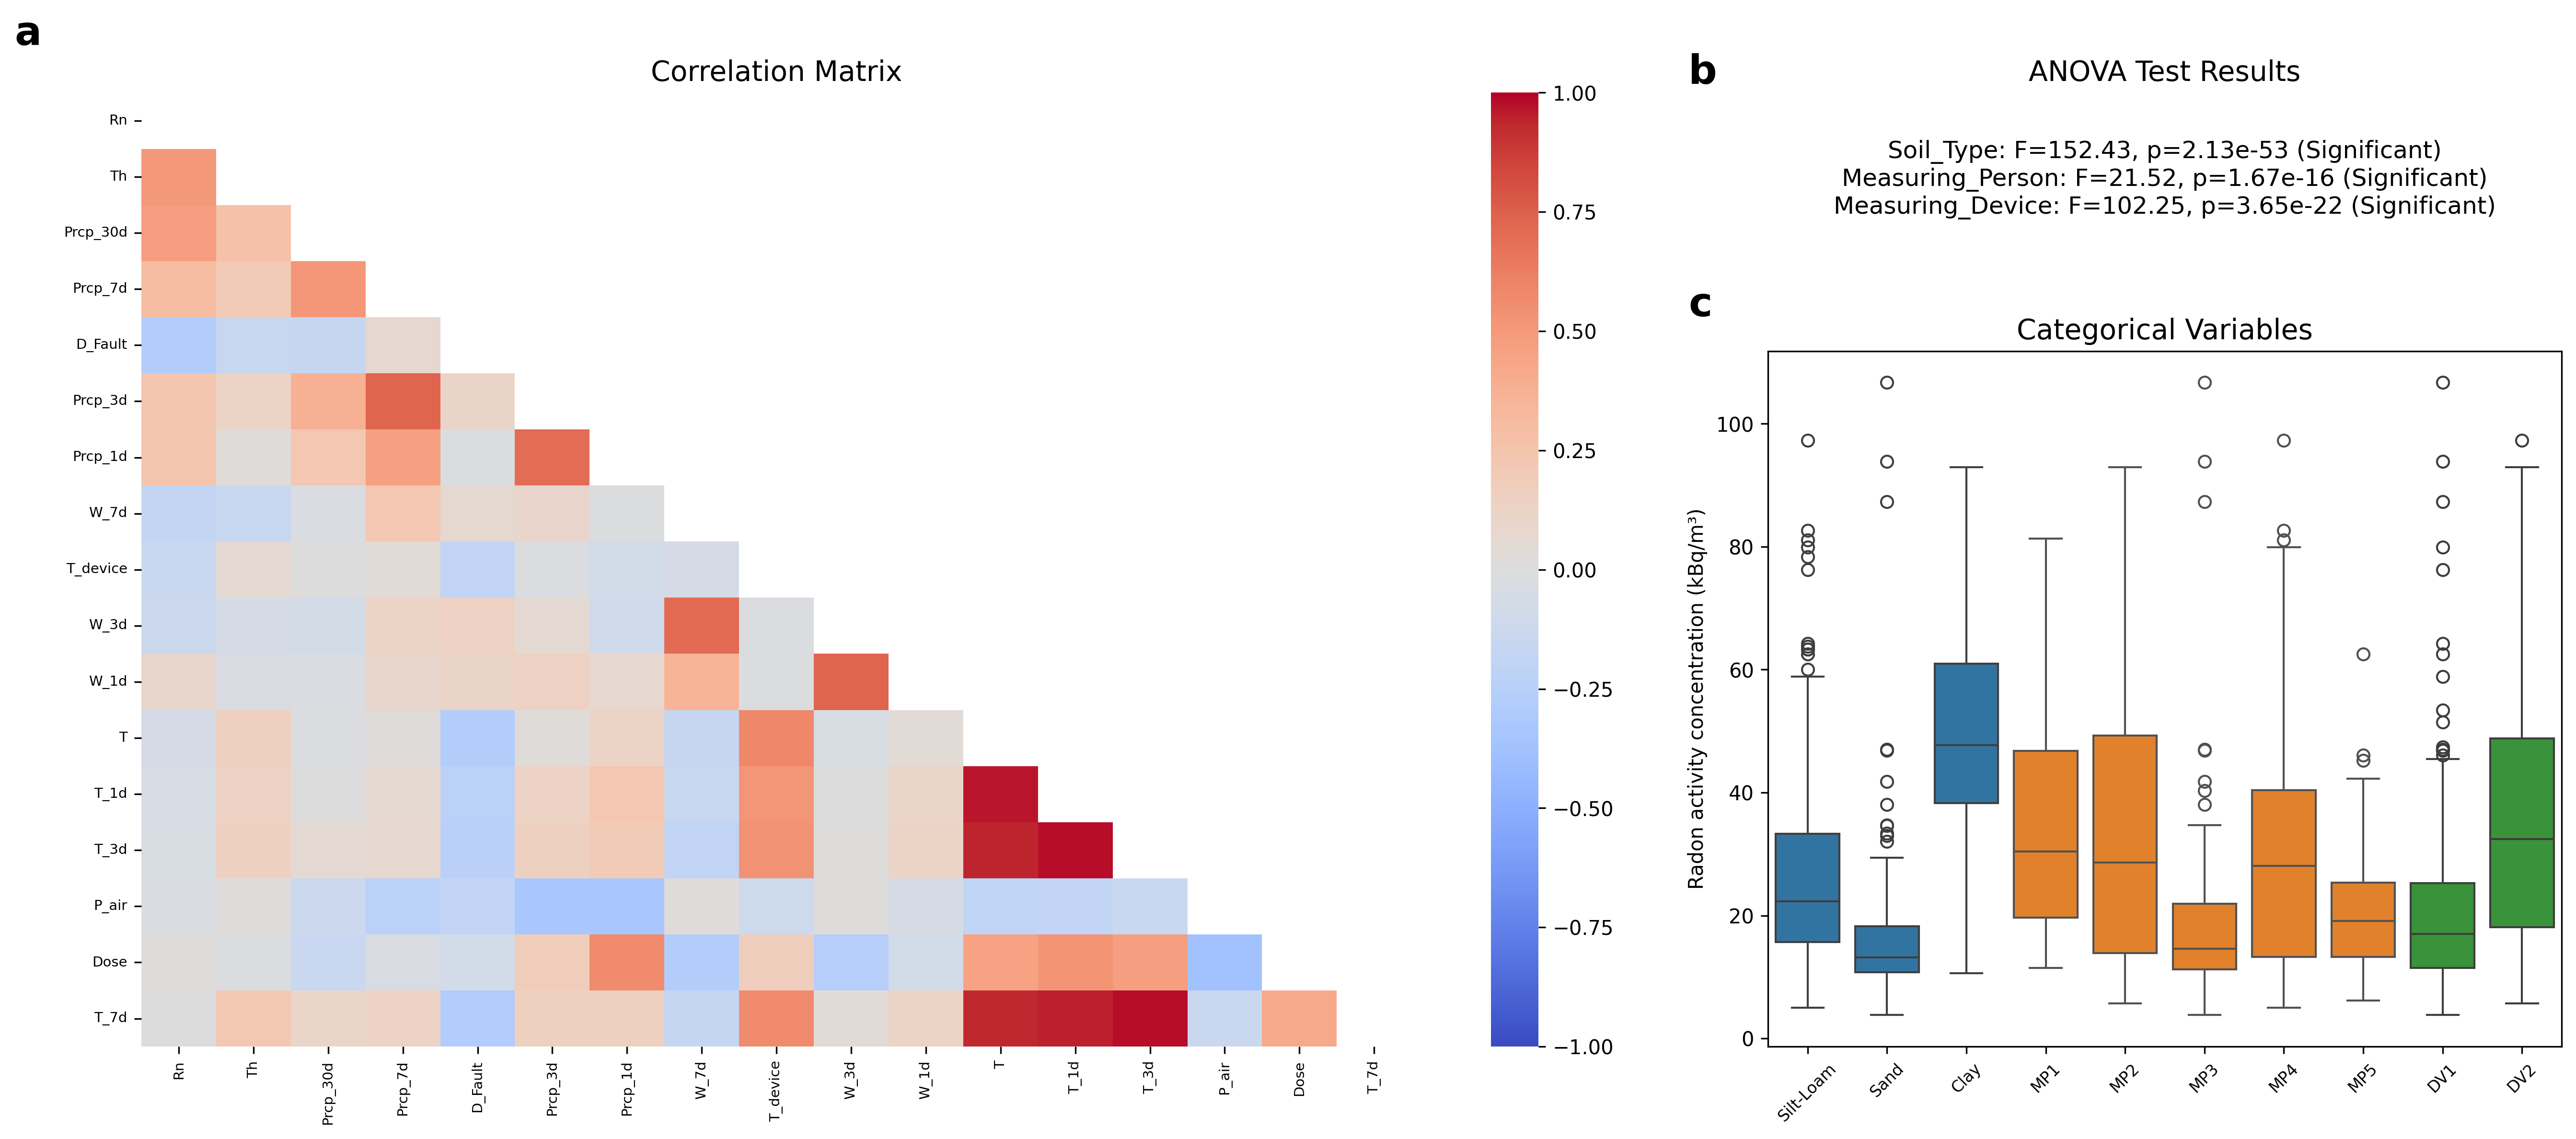

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

kzm_df = pd.read_excel('data.xlsx')

kzm_df = kzm_df[~((kzm_df['Editor'] == 'Sarah') & (kzm_df['Distance2Closest_Fault'] > 600))] # excludes datapoints marked in Fig 1

# Rename columns
kzm_df.rename(columns={
    'Radon_Level': 'Rn_Concentration',
    'Radon_Level_Error': 'Rn_Error',
    'Thorium_Level': 'Th_Concentration',
    'Thorium_Level_Error': 'Th_Error',
    'Soil_Type': 'Soil_Type',
    'Air_Pressure': 'Air_Pressure',
    'Device_Temperature': 'Device_Temp',
    'Average_Temperature': 'Avg_Temp',
    'Editor': 'Measuring_Person',
    'Measuring_Device': 'Measuring_Device',
    'Temperature_1_Day_Before': 'Temp_1d_Before',
    'Average_Temperature_3_Days_Before': 'Avg_Temp_3d_Before',
    'Average_Temperature_7_Days_Before': 'Avg_Temp_7d_Before',
    'Wind_Speed_1_Day_Before': 'Wind_1d_Before',
    'Average_Wind_Speed_3_Days_Before': 'Avg_Wind_3d_Before',
    'Average_Wind_Speed_7_Days_Before': 'Avg_Wind_7d_Before',
    'Precipitation_1_Day_Before': 'Precip_1d_Before',
    'Sum_Precipitation_3_Days_Before': 'Sum_Precip_3d_Before',
    'Sum_Precipitation_7_Days_Before': 'Sum_Precip_7d_Before',
    'Sum_Precipitation_30_Days_Before': 'Sum_Precip_30d_Before',
    'Ambient_Dose_Equivalent': 'Amb_Dose_Equiv',
    'Distance2NWSE': 'Dist_2_NWSE',
    'Distance2NS': 'Dist_2_NS',
    'Distance2Closest_Fault': 'Dist_2_Fault'
}, inplace=True)

# Drop columns
vars_to_drop = ['Season']
kzm_df = kzm_df.drop(columns=vars_to_drop)

# Identify categorical and numerical variables
categorical_vars_kzm = kzm_df.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()
numerical_vars_kzm = kzm_df.select_dtypes(include='number').columns.tolist()

# Ensure 'Measuring_Person' and 'Measuring_Device' are treated as categorical variables
kzm_df['Measuring_Person'] = kzm_df['Measuring_Person'].astype('category')
kzm_df['Measuring_Device'] = kzm_df['Measuring_Device'].astype('category')

# Anonymize measuring persons and devices
kzm_df['Measuring_Person'] = kzm_df['Measuring_Person'].cat.rename_categories({
    old_name: f'MP{num+1}' for num, old_name in enumerate(kzm_df['Measuring_Person'].cat.categories)
})
kzm_df['Measuring_Device'] = kzm_df['Measuring_Device'].cat.rename_categories({
    old_name: f'DV{num+1}' for num, old_name in enumerate(kzm_df['Measuring_Device'].cat.categories)
})

# anova function
def perform_anova(data, numerical_var, categorical_vars):
    anova_results = {}
    for cat_var in categorical_vars:
        groups = [group[numerical_var].dropna() for name, group in data.groupby(cat_var) if not group[numerical_var].empty]
        if len(groups) > 1:
            f_stat, p_value = f_oneway(*groups)
            anova_results[cat_var] = {'F-Statistic': f_stat, 'p-Value': p_value}
        else:
            anova_results[cat_var] = {'F-Statistic': None, 'p-Value': None, 'Note': 'Insufficient data'}
    return anova_results

# print_anova_results function
def print_anova_results(anova_results_kzm):
    results = []
    for var, stats in anova_results_kzm.items():
        if stats['p-Value'] is not None:
            significance = "Significant" if stats['p-Value'] < 0.05 else "Not Significant"
            results.append(f"{var}: F={stats['F-Statistic']:.2f}, p={stats['p-Value']:.2e} ({significance})")
        else:
            results.append(f"{var}: Insufficient data for ANOVA")
    return "\n".join(results)

# Perform ANOVA test
anova_results_kzm = perform_anova(kzm_df, 'Rn_Concentration', categorical_vars_kzm)

# Get ANOVA test results as string
anova_results_str = print_anova_results(anova_results_kzm)

# Filter significant categorical variables
significant_cat_vars = [var for var, stats in anova_results_kzm.items() if stats['p-Value'] is not None and stats['p-Value'] < 0.05]

# Calculate correlation matrix for numerical variables
correlation_matrix = kzm_df[numerical_vars_kzm].rename(columns={
    'Rn_Concentration': 'Rn',
    'Rn_Error': 'Rn_Err',
    'Th_Concentration': 'Th',
    'Th_Error': 'Th_Err',
    'Air_Pressure': 'P_air',
    'Device_Temp': 'T_device',
    'Avg_Temp': 'T',
    'Temp_1d_Before': 'T_1d',
    'Avg_Temp_3d_Before': 'T_3d',
    'Avg_Temp_7d_Before': 'T_7d',
    'Wind_1d_Before': 'W_1d',
    'Avg_Wind_3d_Before': 'W_3d',
    'Avg_Wind_7d_Before': 'W_7d',
    'Precip_1d_Before': 'Prcp_1d',
    'Sum_Precip_3d_Before': 'Prcp_3d',
    'Sum_Precip_7d_Before': 'Prcp_7d',
    'Sum_Precip_30d_Before': 'Prcp_30d',
    'Amb_Dose_Equiv': 'Dose',
    'Dist_2_NWSE': 'D_NWSE',
    'Dist_2_NS': 'D_NS',
    'Dist_2_Fault': 'D_Fault'
}).corr()

# Define columns to drop
columns_to_drop = correlation_matrix.columns[
    correlation_matrix.columns.str.contains('Coordinate|ID|D_N|Err', case=False)
]

# Drop specified columns from correlation matrix on both axes
correlation_matrix = correlation_matrix.drop(columns=columns_to_drop, axis=1).drop(index=columns_to_drop, axis=0)

# Sort the correlation matrix by the correlation with 'Rn'
sorted_corr_matrix = correlation_matrix.reindex(correlation_matrix['Rn'].abs().sort_values(ascending=False).index, axis=0)
sorted_corr_matrix = sorted_corr_matrix.reindex(correlation_matrix['Rn'].abs().sort_values(ascending=False).index, axis=1)

# Create a figure with the desired layout
fig = plt.figure(figsize=(18, 8), dpi=300)
gs = fig.add_gridspec(2, 2, width_ratios=[2, 1], height_ratios=[0.2, 0.8])

# Correlation matrix plot spanning the first column
ax0 = fig.add_subplot(gs[:, 0])
mask = np.triu(np.ones_like(sorted_corr_matrix, dtype=bool))
sns.heatmap(sorted_corr_matrix, ax=ax0, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, annot_kws={'fontsize': 7}, mask=mask)
ax0.set_title('Correlation Matrix', fontsize=14)
ax0.tick_params(axis='both', labelsize=7)
ax0.text(-0.1, 1.05, 'a', transform=ax0.transAxes, fontsize=20, weight='bold')

# ANOVA results text plot
ax1 = fig.add_subplot(gs[0, 1])
ax1.text(0.5, 0.5, anova_results_str, ha='center', va='center', fontsize=12, wrap=True)
ax1.set_title('ANOVA Test Results', fontsize=14)
ax1.axis('off')
ax1.text(-0.1, 1.05, 'b', transform=ax1.transAxes, fontsize=20, weight='bold')

# Boxplots for significant categorical variables
ax2 = fig.add_subplot(gs[1, 1])
for var in significant_cat_vars:
    sns.boxplot(x=var, y=kzm_df['Rn_Concentration'] / 1e3, data=kzm_df, ax=ax2)
ax2.set_title('Categorical Variables', fontsize=14)
ax2.set_ylabel('Radon activity concentration (kBq/m³)', fontsize=10)
ax2.set_xlabel('')
ax2.tick_params(axis='x', rotation=45, labelsize=8)
ax2.text(-0.1, 1.05, 'c', transform=ax2.transAxes, fontsize=20, weight='bold')

plt.tight_layout()
plt.savefig('Figure3.png',dpi=300)
plt.show()


High resolved version

In [4]:

# Create a figure with the desired layout
fig = plt.figure(figsize=(36, 16), dpi=300)
gs = fig.add_gridspec(2, 2, width_ratios=[2, 1], height_ratios=[0.2, 0.8])

# Correlation matrix plot spanning the first column
ax0 = fig.add_subplot(gs[:, 0])
mask = np.triu(np.ones_like(sorted_corr_matrix, dtype=bool))
sns.heatmap(sorted_corr_matrix, ax=ax0, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, annot_kws={'fontsize': 14}, mask=mask)
ax0.set_title('Correlation Matrix', fontsize=14)
ax0.tick_params(axis='both', labelsize=14)
ax0.text(-0.1, 1.05, 'a', transform=ax0.transAxes, fontsize=20, weight='bold')

# ANOVA results text plot
ax1 = fig.add_subplot(gs[0, 1])
ax1.text(0.5, 0.5, anova_results_str, ha='center', va='center', fontsize=14, wrap=True)
ax1.set_title('ANOVA Test Results', fontsize=14)
ax1.axis('off')
ax1.text(-0.1, 1.05, 'b', transform=ax1.transAxes, fontsize=20, weight='bold')

# Boxplots for significant categorical variables
ax2 = fig.add_subplot(gs[1, 1])
for var in significant_cat_vars:
    sns.boxplot(x=var, y=kzm_df['Rn_Concentration'] / 1e3, data=kzm_df, ax=ax2)
ax2.set_title('Categorical Variables', fontsize=14)
ax2.set_ylabel('Radon activity concentration (kBq/m³)', fontsize=14)
ax2.set_xlabel('')
ax2.tick_params(axis='x', rotation=45, labelsize=14)
ax2.text(-0.1, 1.05, 'c', transform=ax2.transAxes, fontsize=20, weight='bold')
ax2.tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.savefig('FigA1.png', dpi=300)
plt.show()
